# Synthesize Speech from Text

This notebook is used to explore synthesizing speech from text.

In [1]:
%matplotlib inline

import sys

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

## Load checkpoints

In [2]:
import os

feature_model_checkpoint = ('/home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/feature_model/07_17/'
                            'baseline/checkpoints/1531942185/step_33653.pt')
signal_model_checkpoint = ('/home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/signal_model/07_28/'
                           'baseline_predicted/checkpoints/1532901240/step_1084157.pt')

assert os.path.isfile(feature_model_checkpoint)
assert os.path.isfile(signal_model_checkpoint)

In [3]:
import torch

from src.bin.feature_model._utils import load_checkpoint
from src.bin.feature_model._utils import set_hparams

set_hparams()
checkpoint = load_checkpoint(feature_model_checkpoint, torch.device('cuda'))
text_encoder = checkpoint['text_encoder']
feature_model = checkpoint['model']
'Loaded feature model at step %d' % checkpoint['step']

INFO:src.utils.utils:Loading: /home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/feature_model/07_17/baseline/checkpoints/1531942185/step_33653.pt


'Loaded feature model at step 33653'

In [4]:
from src.bin.signal_model._utils import load_checkpoint
from src.bin.signal_model._utils import set_hparams

set_hparams()
checkpoint = load_checkpoint(signal_model_checkpoint, torch.device('cpu'))
signal_model = checkpoint['model']
'Loaded signal model at step %d' % checkpoint['step']

INFO:src.utils.utils:Loading: /home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/signal_model/07_28/baseline_predicted/checkpoints/1532901240/step_1084157.pt


'Loaded signal model at step 1084157'

## Predict

In [5]:
text = ("But it's also perfect for celebrating life's little victories. Like opening a really tough jar. Or flossing, two days in a row. Or not texting your ex, even though you're desperately want to. Shambong. Make any moment classy.")

In [6]:
# Ensure your text does not contain unknown characters
assert text_encoder.decode(text_encoder.encode(text)) == text

torch.set_grad_enabled(False)
feature_model.eval()
_ = signal_model.eval() # ``_ = `` prevents printing

Text Shape: torch.Size([225, 1])
Spectrogram Shape: torch.Size([2000, 1, 128])


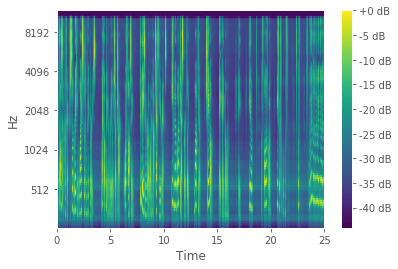

In [7]:
from src.utils import plot_log_mel_spectrogram

encoded = text_encoder.encode(text)
encoded = encoded.unsqueeze(1).to(torch.device('cuda'))
# predicted_frames [num_frames, batch_size, frame_channels]
_, predicted_frames, _, _ = feature_model(tokens=encoded)

print('Text Shape:', encoded.shape)
print('Spectrogram Shape:', predicted_frames.shape)
_ = plot_log_mel_spectrogram(predicted_frames[:, 0, :].cpu().numpy())

In [8]:
from src.utils import combine_signal 

# [num_frames, batch_size, frame_channels] → [num_frames, frame_channels]
predicted_frames = predicted_frames.squeeze(1)
padded_predicted_frames = torch.nn.functional.pad(predicted_frames, (0, 0, 5, 5)).cpu()
padded_predicted_frames = padded_predicted_frames.unsqueeze(0)
print('Padded spectrogram Shape:', padded_predicted_frames.shape)
# [batch_size, signal_length]
predicted_coarse, predicted_fine, _ = signal_model.infer(padded_predicted_frames)

predicted_coarse = predicted_coarse.squeeze(0).cpu()
predicted_fine = predicted_fine.squeeze(0).cpu()
signal = combine_signal(predicted_coarse, predicted_fine)

Padded spectrogram Shape: torch.Size([1, 2010, 128])


100%|██████████| 600000/600000 [06:42<00:00, 1491.98it/s]


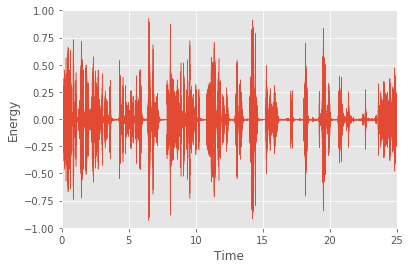

In [9]:
from src.utils import plot_waveform

_ = plot_waveform(signal.numpy())

In [10]:
from IPython.display import Audio

Audio(signal.numpy())